In [496]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression


In [497]:
calls=pd.read_csv("calls.csv")
customers=pd.read_csv("customerss.csv")
sentiment_statistics=pd.read_csv("sentiment_statistics.csv")
reason=pd.read_csv("reason.csv")

In [ ]:
print(calls.head())
print(customers.head())
print(sentiment_statistics.head())
print(reason.head())

In [498]:
calls.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...


In [499]:
customers.head()

,customer_id,customer_name,elite_level_code
0,2033123310,Matthew Foster,4.0
1,8186702651,Tammy Walters,NaN
2,2416856629,Jeffery Dixon,NaN
3,1154544516,David Wilkins,2.0
4,5214456437,Elizabeth Daniels,0.0


In [500]:
reason.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [501]:
sentiment_statistics.head()

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35


In [ ]:
print(calls.info())
print(customers.info())
print(sentiment_statistics.info())
print(reason.info())

In [502]:
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   call_id                  71810 non-null  int64 
 1   customer_id              71810 non-null  int64 
 2   agent_id                 71810 non-null  int64 
 3   call_start_datetime      71810 non-null  object
 4   agent_assigned_datetime  71810 non-null  object
 5   call_end_datetime        71810 non-null  object
 6   call_transcript          71810 non-null  object
dtypes: int64(3), object(4)
memory usage: 3.8+ MB


In [503]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       71810 non-null  int64  
 1   customer_name     71810 non-null  object 
 2   elite_level_code  46043 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [504]:
reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   call_id              66653 non-null  int64 
 1   primary_call_reason  66653 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [505]:
sentiment_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71810 non-null  int64  
 1   agent_id                 71810 non-null  int64  
 2   agent_tone               71593 non-null  object 
 3   customer_tone            71810 non-null  object 
 4   average_sentiment        71701 non-null  float64
 5   silence_percent_average  71810 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 3.3+ MB


# Missing calls data and percent value

In [509]:
calls_missing_total=calls.isnull().sum().sort_values(ascending=False)
calls_missing_percent=(calls.isnull().sum()/calls.isnull().count()).sort_values(ascending=False)
missing_calls_data=pd.concat([calls_missing_total,calls_missing_percent],axis=1,keys=['calls_missing_total','calls_missing_percent'])
missing_calls_data

,calls_missing_total,calls_missing_percent
call_id,0,0.0
customer_id,0,0.0
agent_id,0,0.0
call_start_datetime,0,0.0
agent_assigned_datetime,0,0.0
call_end_datetime,0,0.0
call_transcript,0,0.0


# Missing customer data and percent value

In [517]:
customer_missing_total=customers.isnull().sum().sort_values(ascending=False)
customer_missing_percent=(customers.isnull().sum()/customers.isnull().count()).sort_values(ascending=False)
missing_customers_data=pd.concat([customer_missing_total,customer_missing_percent],axis=1,keys=['customer_missing_total','customer_missing_percent'])
missing_customers_data

,customer_missing_total,customer_missing_percent
elite_level_code,25767,0.358822
customer_id,0,0.000000
customer_name,0,0.000000


# Missing sentiment statistics and percent value

In [513]:
missing_sentiment_statistics_total=sentiment_statistics.isnull().sum().sort_values(ascending=False)
missing_sentiment_statistics_percent=(sentiment_statistics.isnull().sum()/sentiment_statistics.isnull().count()).sort_values(ascending=False)
missing_sentiment_statistics_data=pd.concat([missing_sentiment_statistics_total,missing_sentiment_statistics_percent],axis=1,keys=['missing_sentiment_statistics_total','missing_sentiment_statistics_percent'])
missing_sentiment_statistics_data

,missing_sentiment_statistics_total,missing_sentiment_statistics_percent
agent_tone,217,0.003022
average_sentiment,109,0.001518
call_id,0,0.000000
agent_id,0,0.000000
customer_tone,0,0.000000
silence_percent_average,0,0.000000


# Missing reason and its percent value

In [515]:
missing_reason_total=reason.isnull().sum().sort_values(ascending=False)
missing_reason_percent=(reason.isnull().sum()/reason.isnull().count()).sort_values(ascending=False)
missing_reason_data=pd.concat([missing_reason_total,missing_reason_percent],axis=1,keys=['missing_reason_total','missing_reason_percent'])
missing_reason_data

,missing_reason_total,missing_reason_percent
call_id,0,0.0
primary_call_reason,0,0.0


In [518]:
# Visualization used to find out the most frequent value of elite level code which is to be filled in place of null values

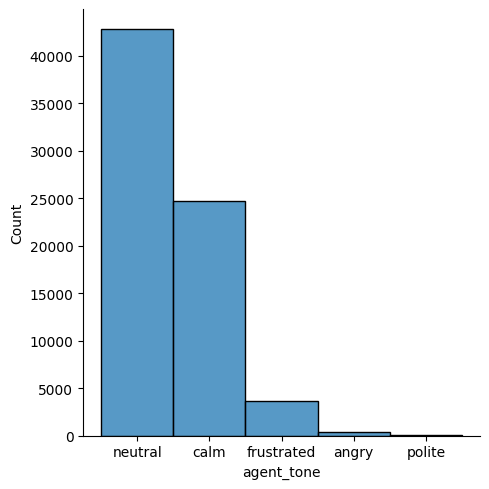

In [519]:
sns.displot(sentiment_statistics["agent_tone"])

# Distribution of average sentiment

In [520]:
#visualization used to find out which value should be put inplace of null values

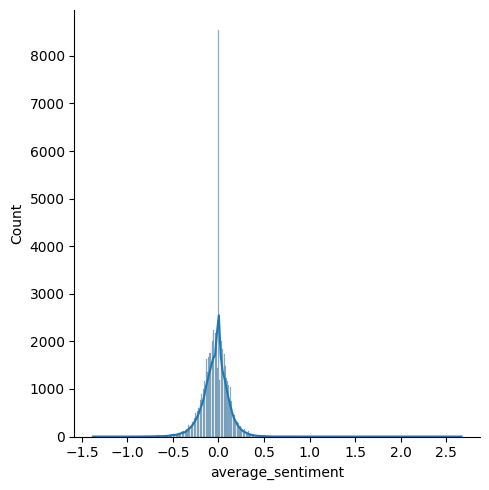

In [521]:
sns.displot(sentiment_statistics.average_sentiment,kde=True)

In [522]:
#filling missing value
sentiment_statistics["agent_tone"].fillna(statistics.mode(sentiment_statistics.agent_tone),inplace=True)

C:\Users\JEEVAN JYOTI\AppData\Local\Temp\ipykernel_30036\2364247671.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sentiment_statistics["agent_tone"].fillna(statistics.mode(sentiment_statistics.agent_tone),inplace=True)


In [523]:
sentiment_statistics.isnull().sum()

call_id                      0
agent_id                     0
agent_tone                   0
customer_tone                0
average_sentiment          109
silence_percent_average      0
dtype: int64

In [524]:
#filling missing value in average sentiment
sentiment_statistics["average_sentiment"].fillna(np.mean(sentiment_statistics.average_sentiment),inplace=True)

C:\Users\JEEVAN JYOTI\AppData\Local\Temp\ipykernel_30036\1214510281.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sentiment_statistics["average_sentiment"].fillna(np.mean(sentiment_statistics.average_sentiment),inplace=True)


In [525]:
sentiment_statistics.isnull().sum()

call_id                    0
agent_id                   0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
dtype: int64

In [526]:
#To remove duplicates if present in the data

In [528]:
sentiment_statistics.drop_duplicates(inplace=True)
reason.drop_duplicates(inplace=True)
customers.drop_duplicates(inplace=True)
calls.drop_duplicates(inplace=True)



#### To change the format from object to Date and time

In [532]:
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

In [534]:
#checking the info of calls dataset after changing the format
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id                 71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(1)
memory usage: 3.8+ MB


In [535]:
calls['call_duration'] = (calls['call_end_datetime'] - calls['agent_assigned_datetime']).dt.total_seconds()
calls['wait_time'] = (calls['agent_assigned_datetime'] - calls['call_start_datetime']).dt.total_seconds()
calls['handle_time'] = (calls['call_end_datetime'] - calls['call_start_datetime']).dt.total_seconds()

# Cleaning primary_call_reason column of reason data 

In [553]:
reason["primary_call_reason"] = reason["primary_call_reason"].str.lower().str.strip().str.replace('-', ' ').str.replace('  ', ' ').str.replace('&', 'and')

# 2. Average Handle Time (AHT) and Average Speed to Answer (AST) Calculation

In [554]:
#calculating AHT
AHT=calls["call_duration"].mean()
print(f"Average Handle Time (AHT): {AHT} seconds")

# Calculating AST
AST= calls['wait_time'].mean()
print(f"Average Speed to Answer (AST): {AST} seconds")

Average Handle Time (AHT): 697.0486004734717 seconds
Average Speed to Answer (AST): 437.0675393399248 seconds


In [555]:
# Correlation between Handle time and Waiting time
required_columns=calls[["handle_time","wait_time"]]

# correlation between Handle time and Waiting time

             handle_time  wait_time
handle_time     1.000000   0.165169
wait_time       0.165169   1.000000


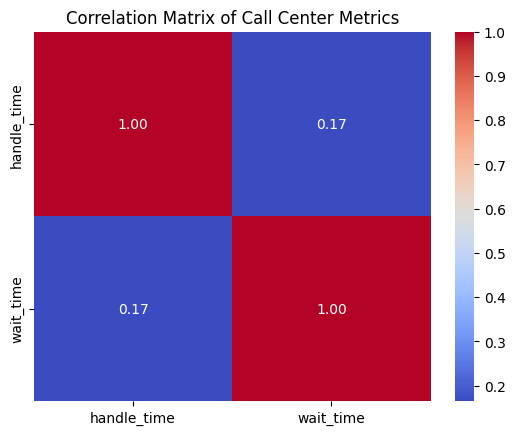

In [556]:
correlation_matrix=required_columns.corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Call Center Metrics")
plt.show()

# Distribution of Handle time

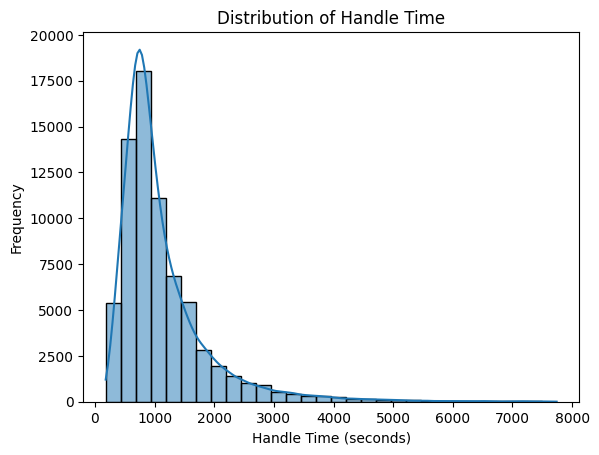

<Figure size 1200x600 with 0 Axes>

In [557]:
sns.histplot(calls.handle_time,bins=30,kde=True)
plt.title("Distribution of Handle Time")
plt.xlabel("Handle Time (seconds)")
plt.ylabel("Frequency")
plt.figure(figsize=(12,6))
plt.show()


#### conversion of log normal distributed value into normally distributed value

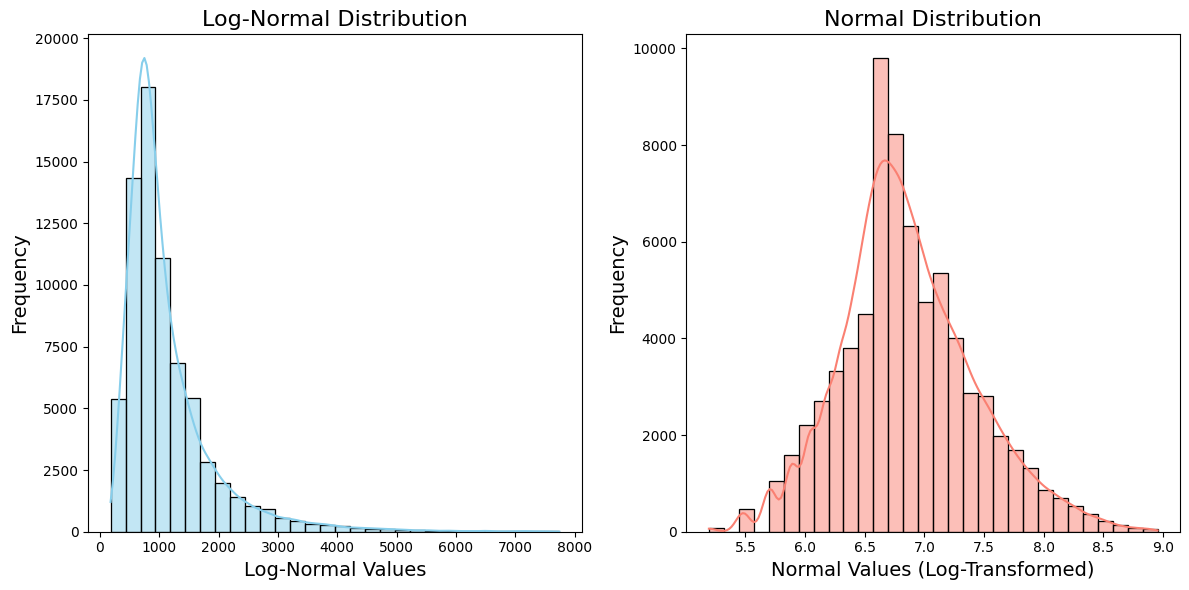

In [558]:
# Convert log-normal to normal by taking the natural logarithm
calls["normalise_handle_time"] = np.log(calls["handle_time"])

# Plot the original log-normal distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(calls["handle_time"], bins=30, kde=True, color='skyblue')
plt.title('Log-Normal Distribution', fontsize=16)
plt.xlabel('Log-Normal Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Plot the transformed normal distribution
plt.subplot(1, 2, 2)
sns.histplot(calls["normalise_handle_time"], bins=30, kde=True, color='salmon')
plt.title('Normal Distribution', fontsize=16)
plt.xlabel('Normal Values (Log-Transformed)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

# Distribution of Waiting time

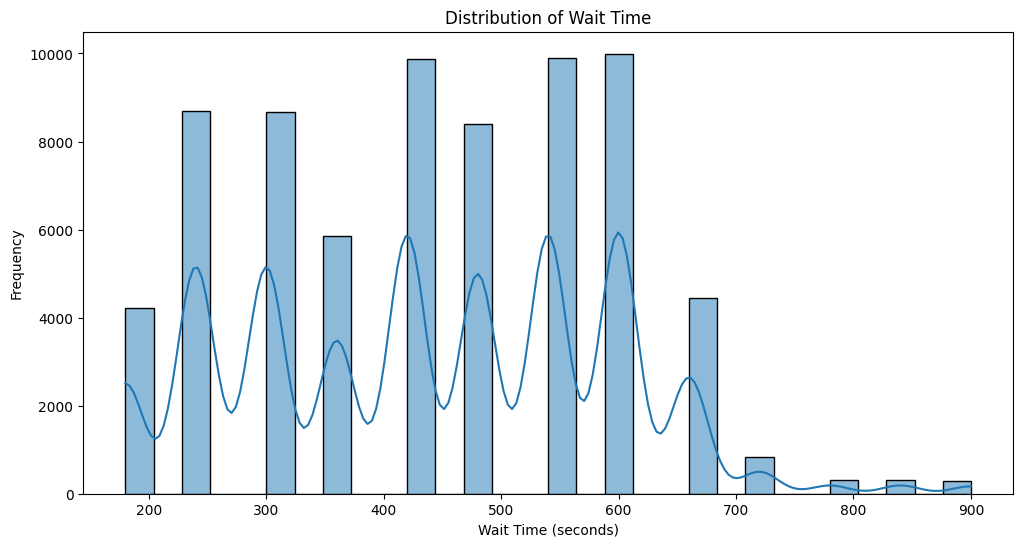

In [559]:
plt.figure(figsize=(12, 6))
sns.histplot(calls['wait_time'], bins=30, kde=True)
plt.title("Distribution of Wait Time")
plt.xlabel("Wait Time (seconds)")
plt.ylabel("Frequency")
plt.show()


In [560]:
def z_score(a):
    result = []
    mean = np.mean(a)
    std = np.std(a)
    for i in a:
        result.append((i - mean) / std)
    return result

calls["z_score"] = z_score(calls["normalise_handle_time"])

# Merging calls and reason data

In [573]:
# Merge calls data with reason data on the call_id
call_and_reason_merge = calls.merge(reason, left_on='call_id', right_on='call_id', how='left')

# Display the first few rows of the merged data to ensure it worked correctly
call_and_reason_merge.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,call_duration,wait_time,handle_time,normalise_handle_time,z_score,primary_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,1860.0,420.0,2280.0,7.731931,1.546469,voluntary cancel
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,720.0,180.0,900.0,6.802395,-0.107207,booking
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1140.0,480.0,1620.0,7.390181,0.938485,irrops
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,420.0,300.0,720.0,6.579251,-0.504187,upgrade
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,540.0,600.0,1140.0,7.038784,0.313336,seating


In [562]:
average_handle_time_each_reason = call_and_reason_merge.groupby('primary_call_reason')['handle_time'].mean().reset_index()
average_handle_time_each_reason

,primary_call_reason,handle_time
0,baggage,875.741525
1,booking,667.963595
2,check in,929.968487
3,checkout,1741.557203
4,communications,1066.687500
5,digital support,878.008163
6,disability,795.632754
7,etc,1507.184874
8,irrops,1145.197205
9,mileage plus,1356.588617


## Merging Calls and sentiment statistics data

In [563]:
# Merge sentiment data with calls data to analyze sentiment
call_and_sentiment = calls.merge(sentiment_statistics, on='call_id', how='left')

# Correlation between Average sentiment and handle time

# Spearman Rank correlation

Correlation between Average Sentiment and Handle Time:
                    average_sentiment  handle_time
average_sentiment           1.000000    -0.071968
handle_time                -0.071968     1.000000


<Axes: >

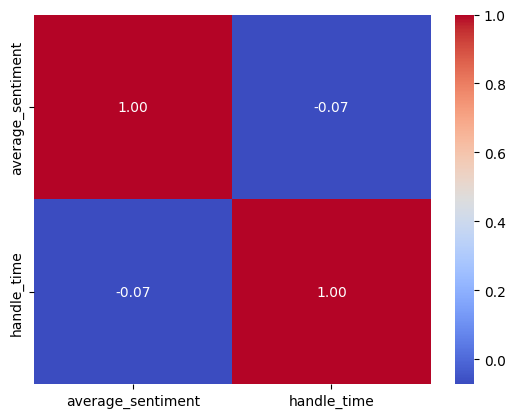

In [564]:
sentiment_spearman_correlation = call_and_sentiment[['average_sentiment', 'handle_time']].corr(method="spearman")
print("Correlation between Average Sentiment and Handle Time:\n", sentiment_spearman_correlation)
sns.heatmap(sentiment_spearman_correlation,annot=True,cmap='coolwarm', fmt=".2f")


# Karl pearson correlation

Correlation between Average Sentiment and Handle Time:
                    average_sentiment  handle_time
average_sentiment           1.000000    -0.067326
handle_time                -0.067326     1.000000


<Axes: >

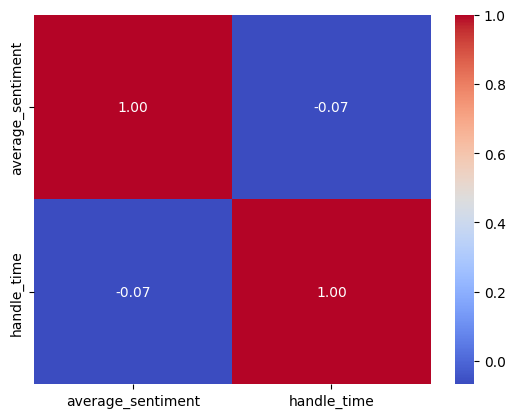

In [565]:
sentiment_correlation = call_and_sentiment[['average_sentiment', 'handle_time']].corr()
print("Correlation between Average Sentiment and Handle Time:\n", sentiment_correlation)
sns.heatmap(sentiment_correlation,annot=True,cmap='coolwarm', fmt=".2f")


In [566]:
sentiment_statistics

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35
...,...,...,...,...,...,...
71805,1563273072,413148,calm,calm,0.05,0.34
71806,8865997781,980156,calm,frustrated,0.03,0.22
71807,8019240181,616988,calm,polite,0.05,0.42
71808,8332067080,161354,neutral,polite,-0.07,0.13


# Sentiment and Silence Analysis

In [567]:
# Correlation between sentiment and AHT
sentiment_aht_corr = sentiment_statistics['average_sentiment'].corr(calls['call_duration'])
print(f"Correlation between sentiment and AHT: {sentiment_aht_corr:.2f}")

# Investigate silence percentage and AHT
silence_aht_corr = sentiment_statistics['silence_percent_average'].corr(calls['call_duration'])
print(f"Correlation between silence and AHT: {silence_aht_corr:.2f}")


Correlation between sentiment and AHT: -0.08
Correlation between silence and AHT: 0.41


# correlation between primary call reason and  handle time

In [568]:
reason["primary_call_reason"] = reason["primary_call_reason"].str.lower().str.strip().str.replace('-', ' ').str.replace('  ', ' ').str.replace('&', 'and')
# Check the frequency of common call reasons
call_reason_counts = reason['primary_call_reason'].value_counts().sort_index(ascending=True)
print("Call Reason Counts:\n", call_reason_counts)

Call Reason Counts:
 primary_call_reason
baggage                   2832
booking                   2637
check in                  1904
checkout                  1888
communications            3840
digital support           1225
disability                 403
etc                        952
irrops                   13311
mileage plus              5851
other topics               818
post flight               4330
products and services     3332
schedule change            731
seating                   6365
traveler updates           937
unaccompanied minor        104
upgrade                   2738
voluntary cancel          1607
voluntary change         10848
Name: count, dtype: int64


In [569]:
dummies1 = pd.get_dummies(call_and_reason_merge, columns=['primary_call_reason'], drop_first=True)

In [570]:
dummies1.columns[9:]

Index(['handle_time', 'normalise_handle_time', 'z_score',
       'primary_call_reason_booking', 'primary_call_reason_check in',
       'primary_call_reason_checkout', 'primary_call_reason_communications',
       'primary_call_reason_digital support', 'primary_call_reason_disability',
       'primary_call_reason_etc', 'primary_call_reason_irrops',
       'primary_call_reason_mileage plus', 'primary_call_reason_other topics',
       'primary_call_reason_post flight',
       'primary_call_reason_products and services',
       'primary_call_reason_schedule change', 'primary_call_reason_seating',
       'primary_call_reason_traveler updates',
       'primary_call_reason_unaccompanied minor',
       'primary_call_reason_upgrade', 'primary_call_reason_voluntary cancel',
       'primary_call_reason_voluntary change'],
      dtype='object')

In [571]:
primary_call_reason_handle_time_corr= dummies1[dummies1.columns[9:]].corr()
primary_call_reason_handle_time_corr.iloc[0].sort_values(ascending=False)

handle_time                                  1.000000
z_score                                      0.913718
normalise_handle_time                        0.913718
primary_call_reason_checkout                 0.127190
primary_call_reason_post flight              0.118853
primary_call_reason_mileage plus             0.084432
primary_call_reason_etc                      0.055102
primary_call_reason_voluntary cancel         0.024535
primary_call_reason_voluntary change         0.024471
primary_call_reason_irrops                   0.006735
primary_call_reason_unaccompanied minor      0.003561
primary_call_reason_traveler updates        -0.007450
primary_call_reason_communications          -0.020422
primary_call_reason_products and services   -0.023922
primary_call_reason_disability              -0.032402
primary_call_reason_seating                 -0.035088
primary_call_reason_check in                -0.042931
primary_call_reason_digital support         -0.042992
primary_call_reason_upgrade 

<Axes: >

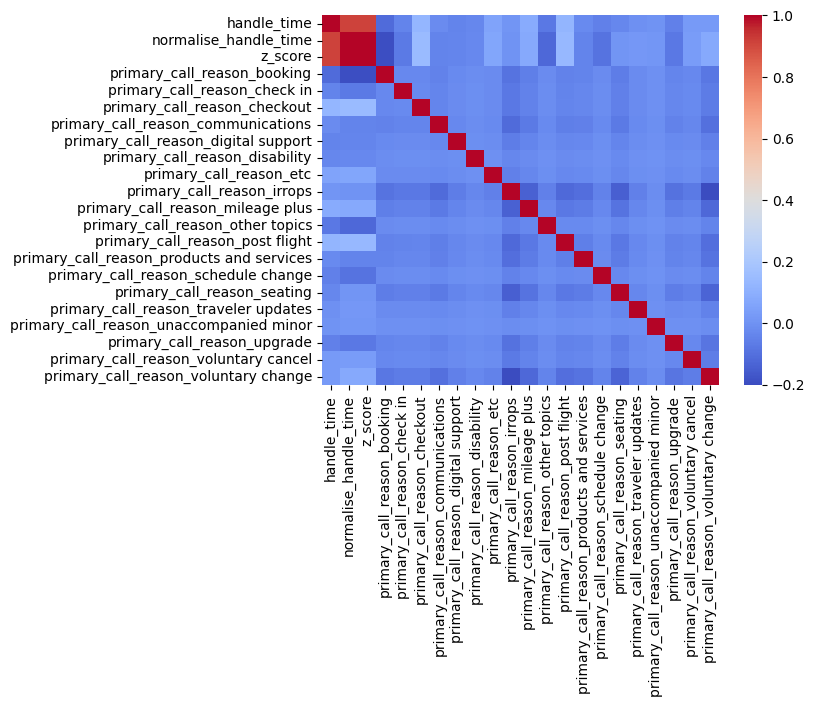

In [572]:
sns.heatmap(primary_call_reason_handle_time_corr,cmap="coolwarm")

# Agent taking more handling time


In [574]:
agent_taking_more_handling_time=call_and_reason_merge[call_and_reason_merge.z_score>3]

In [575]:
len(agent_taking_more_handling_time)

295

###  which are the primary reason for which agent take more handling time

In [576]:
agent_taking_more_handling_time["primary_call_reason"].value_counts()

primary_call_reason
post flight              50
mileage plus             49
irrops                   45
checkout                 30
check in                 15
voluntary change         15
communications           14
etc                      12
products and services    12
voluntary cancel         11
seating                   9
booking                   6
upgrade                   4
Name: count, dtype: int64

# Average handle time and speed to answer by primary call reasons

In [577]:
# Calculate average handle time and wait time by primary call reason
avg_handle_time_by_reason = call_and_reason_merge.groupby('primary_call_reason')['handle_time'].mean().sort_values(ascending=False)
avg_wait_time_by_reason = call_and_reason_merge.groupby('primary_call_reason')['wait_time'].mean().sort_values(ascending=False)

# Display the results
print("Average Handle Time by Primary Call Reason:\n", avg_handle_time_by_reason)
print("\nAverage Speed to Answer by Primary Call Reason:\n", avg_wait_time_by_reason)

Average Handle Time by Primary Call Reason:
 primary_call_reason
checkout                 1741.557203
etc                      1507.184874
post flight              1502.327945
mileage plus             1356.588617
voluntary cancel         1261.381456
unaccompanied minor      1207.500000
voluntary change         1179.640487
irrops                   1145.197205
traveler updates         1083.265742
communications           1066.687500
products and services    1049.009604
seating                  1045.819324
upgrade                   930.832725
check in                  929.968487
digital support           878.008163
baggage                   875.741525
disability                795.632754
schedule change           730.834473
booking                   667.963595
other topics              588.850856
Name: handle_time, dtype: float64

Average Speed to Answer by Primary Call Reason:
 primary_call_reason
checkout                 724.703390
traveler updates         690.032017
unaccompanied minor

# Identify common call reasons with high AHT (e.g., over 900 seconds)

In [578]:
# Identify common call reasons with high AHT (e.g., over 900 seconds)
high_aht_reasons = avg_handle_time_by_reason[avg_handle_time_by_reason > 900]
print("Call Reasons with High AHT:\n", high_aht_reasons)


Call Reasons with High AHT:
 primary_call_reason
checkout                 1741.557203
etc                      1507.184874
post flight              1502.327945
mileage plus             1356.588617
voluntary cancel         1261.381456
unaccompanied minor      1207.500000
voluntary change         1179.640487
irrops                   1145.197205
traveler updates         1083.265742
communications           1066.687500
products and services    1049.009604
seating                  1045.819324
upgrade                   930.832725
check in                  929.968487
Name: handle_time, dtype: float64


# Identify call reasons with high AST (e.g., over 600 seconds)

In [579]:
# Identify call reasons with high AST (e.g., over 600 seconds)
high_ast_reasons = avg_wait_time_by_reason[avg_wait_time_by_reason > 600]
print("\nCall Reasons with High AST:\n", high_ast_reasons)



Call Reasons with High AST:
 primary_call_reason
checkout               724.703390
traveler updates       690.032017
unaccompanied minor    688.269231
Name: wait_time, dtype: float64


# Percentage Difference Between Frequent and Infrequent Call Reasons

In [580]:
# Frequency of call reasons
call_reason_freq = reason['primary_call_reason'].value_counts()

# Most frequent and least frequent call reasons
most_frequent = call_reason_freq.index[0]
least_frequent = call_reason_freq.index[-1]

# Calculate AHT for both
aht_most_frequent = call_and_reason_merge[call_and_reason_merge['primary_call_reason'] == most_frequent]['call_duration'].mean()
aht_least_frequent = call_and_reason_merge[call_and_reason_merge['primary_call_reason'] == least_frequent]['call_duration'].mean()

# Percentage difference
percentage_difference = ((aht_most_frequent - aht_least_frequent) / aht_most_frequent) * 100
print(f"Percentage difference in AHT: {percentage_difference:.2f}%")
print(aht_most_frequent)
print(aht_least_frequent)

Percentage difference in AHT: 33.87%
785.1160694162722
519.2307692307693


# Plotting of average handle time by call reason

C:\Users\JEEVAN JYOTI\AppData\Local\Temp\ipykernel_30036\2576706910.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_handle_time_by_reason.index, y=avg_handle_time_by_reason.values, palette='viridis')


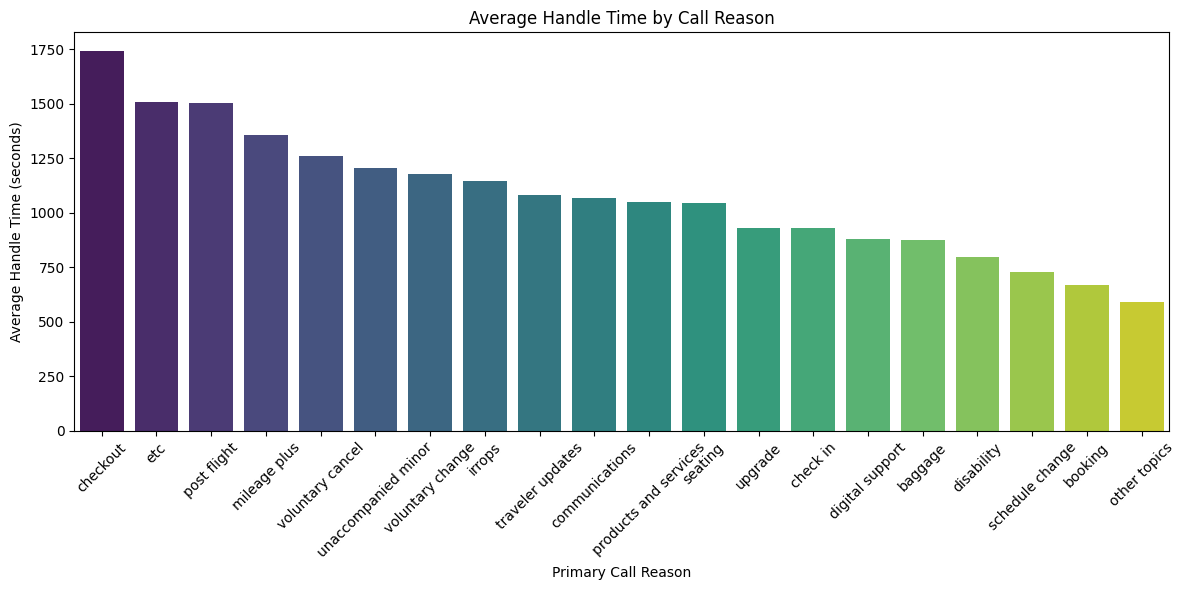

In [581]:
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_handle_time_by_reason.index, y=avg_handle_time_by_reason.values, palette='viridis')
plt.title('Average Handle Time by Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting of average speed to answer by call reason

C:\Users\JEEVAN JYOTI\AppData\Local\Temp\ipykernel_30036\1981685045.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_wait_time_by_reason.index, y=avg_wait_time_by_reason.values, palette='magma')


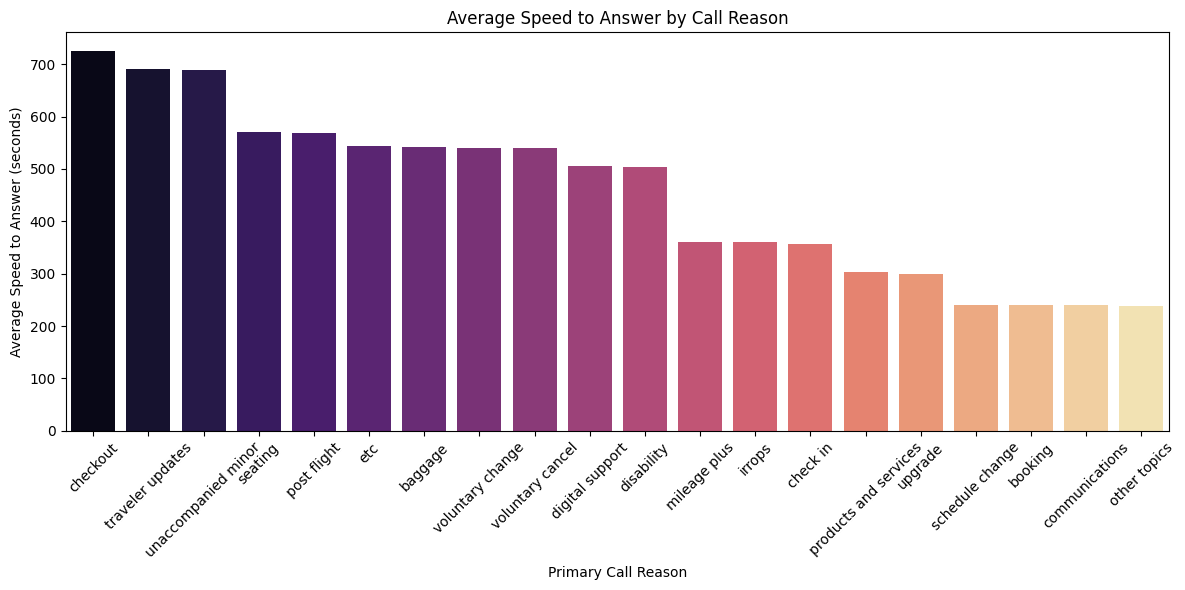

In [582]:
# Visualize average speed to answer by call reason
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_wait_time_by_reason.index, y=avg_wait_time_by_reason.values, palette='magma')
plt.title('Average Speed to Answer by Call Reason')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Speed to Answer (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [188]:
# Create a list of self-service opportunities based on common call reasons
self_service_opportunities = ['Voluntary Change', 'Digital Support', 'Baggage']
print("Potential Self-Service Opportunities:\n", self_service_opportunities)


Potential Self-Service Opportunities:
 ['Voluntary Change', 'Digital Support', 'Baggage']


# contingency table to detect the association between two qualitative data`

In [583]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(sentiment_statistics.agent_tone, sentiment_statistics.customer_tone)
print(contingency_table)
# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(expected)
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")  # If p-value < 0.05, there is a significant association

customer_tone  angry  calm  frustrated  neutral  polite
agent_tone                                             
angry             77    68          86       80      78
calm            4922  4963        4890     4983    4917
frustrated       732   689         760      742     761
neutral         8659  8610        8488     8622    8596
polite            18    17          16       17      19
[[  78.04918535   77.71874391   77.13911711   78.24419997   77.84875366]
 [4950.80629439 4929.84577357 4893.07895836 4963.17643782 4938.09253586]
 [ 739.15989417  736.03046929  730.54115026  741.00676786  737.26171842]
 [8622.5288957  8586.02318619 8521.98858098 8644.07324885 8600.38608829]
 [  17.4557304    17.38182704   17.25219329   17.4993455    17.41090377]]
Chi-Square Statistic: 8.56772176297669
P-Value: 0.9301433455386926


#### The Chi-Square statistic and the p-value help you assess whether there is a significant association between two categorical (qualitative) variables.

1. Chi-Square Statistic:
The Chi-Square statistic measures the difference between the observed frequencies (what actually happened) and the expected frequencies (what would happen if there were no association between the variables). In your case, the Chi-Square statistic is 8.55.
A larger Chi-Square statistic indicates a greater difference between the observed and expected values, meaning the variables are more likely to be associated. 
A smaller value suggests less association.
2. P-Value:
The p-value tells us whether the Chi-Square statistic is large enough to reject the null hypothesis, which assumes that the two variables are independent (i.e., no association between them).
The p-value you obtained is 0.93, which is much larger than the typical significance level (e.g., 0.05).
##### Interpretation:
Chi-Square Statistic (8.55):

This value, though not extremely small, isn't exceptionally large either. It indicates some degree of difference between the observed and expected frequencies, but not enough to strongly indicate an association.
P-Value (0.93):

A p-value of 0.93 means there is no significant association between the two categorical variables. This is because the p-value is much larger than the common threshold (e.g., 0.05 or 0.01).
High p-value (> 0.05): You fail to reject the null hypothesis, meaning the data does not provide enough evidence to suggest there is an association between the variables. They are likely independent of each other.
What We Can Infer:
Since the p-value is very high (0.93), you can conclude that there is no statistically significant relationship between the two categorical variables in question.
The variables are likely independent—meaning changes in one variable do not have a notable effect on the other.

In [468]:
np.mean(calls.z_score)

8.406588334518606e-16

In [466]:
np.mean(calls.normalise_handle_time)

6.862656376813248

# correlation between Agent and Customer tone and average sentiment

In [584]:
dummies = pd.get_dummies(sentiment_statistics, columns=['agent_tone', 'customer_tone'], drop_first=True)

In [585]:
dummies

,call_id,agent_id,average_sentiment,silence_percent_average,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite
0,4667960400,963118,-0.04,0.39,False,False,True,False,False,False,False,False
1,1122072124,519057,0.02,0.35,True,False,False,False,False,False,True,False
2,6834291559,158319,-0.13,0.32,False,False,True,False,False,False,False,True
3,2266439882,488324,-0.20,0.20,False,False,True,False,False,True,False,False
4,1211603231,721730,-0.05,0.35,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
71805,1563273072,413148,0.05,0.34,True,False,False,False,True,False,False,False
71806,8865997781,980156,0.03,0.22,True,False,False,False,False,True,False,False
71807,8019240181,616988,0.05,0.42,True,False,False,False,False,False,False,True
71808,8332067080,161354,-0.07,0.13,False,False,True,False,False,False,False,True


<Axes: >

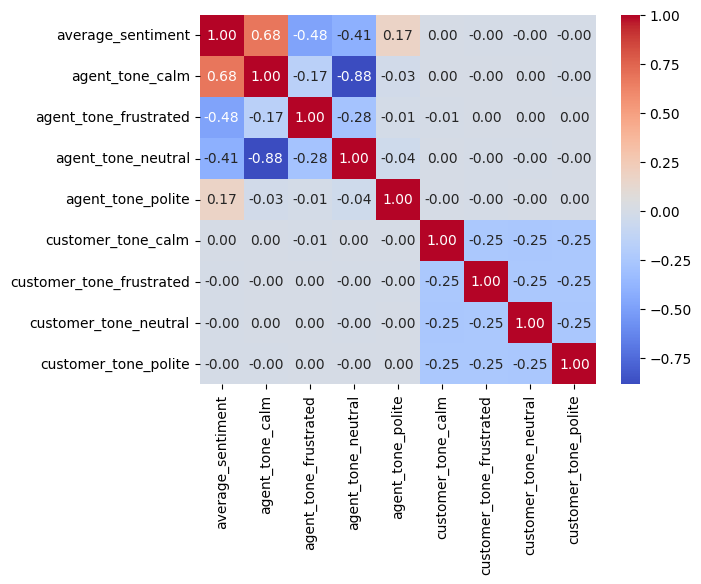

In [586]:
agent_customer_average_sentiment= dummies[['average_sentiment', 'agent_tone_calm', 'agent_tone_frustrated','agent_tone_neutral','agent_tone_polite','customer_tone_calm','customer_tone_frustrated','customer_tone_neutral','customer_tone_polite']].corr()
sns.heatmap(agent_customer_average_sentiment,annot=True,cmap='coolwarm', fmt=".2f")

In [587]:
agent_customer_average_sentiment

,average_sentiment,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite
average_sentiment,1.000000,0.679203,-0.480063,-0.409277,0.171542,0.003535,-0.003361,-0.000666,-0.003323
agent_tone_calm,0.679203,1.000000,-0.168252,-0.883293,-0.025199,0.002431,-0.000226,0.001450,-0.001546
agent_tone_frustrated,-0.480063,-0.168252,1.000000,-0.283891,-0.008099,-0.007425,0.004664,0.000156,0.003745
agent_tone_neutral,-0.409277,-0.883293,-0.283891,1.000000,-0.042519,0.001703,-0.002422,-0.001564,-0.000311
agent_tone_polite,0.171542,-0.025199,-0.008099,-0.042519,1.000000,-0.000382,-0.001257,-0.000499,0.001590
customer_tone_calm,0.003535,0.002431,-0.007425,0.001703,-0.000382,1.000000,-0.248510,-0.250728,-0.249935
customer_tone_frustrated,-0.003361,-0.000226,0.004664,-0.002422,-0.001257,-0.248510,1.000000,-0.249559,-0.248769
customer_tone_neutral,-0.000666,0.001450,0.000156,-0.001564,-0.000499,-0.250728,-0.249559,1.000000,-0.250990
customer_tone_polite,-0.003323,-0.001546,0.003745,-0.000311,0.001590,-0.249935,-0.248769,-0.250990,1.000000


In [588]:
sentiment_statistics

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35
...,...,...,...,...,...,...
71805,1563273072,413148,calm,calm,0.05,0.34
71806,8865997781,980156,calm,frustrated,0.03,0.22
71807,8019240181,616988,calm,polite,0.05,0.42
71808,8332067080,161354,neutral,polite,-0.07,0.13


# Merge sentiment data with the reason data on the call_id

In [590]:
# Merge sentiment data with reason data on the call_id
sentiment_reason_merge= sentiment_statistics.merge(reason, on='call_id', how='left')

# Display the first few rows of the merged data to ensure it worked correctly
sentiment_reason_merge.head()

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average,primary_call_reason
0,4667960400,963118,neutral,angry,-0.04,0.39,voluntary cancel
1,1122072124,519057,calm,neutral,0.02,0.35,booking
2,6834291559,158319,neutral,polite,-0.13,0.32,irrops
3,2266439882,488324,neutral,frustrated,-0.20,0.20,upgrade
4,1211603231,721730,neutral,polite,-0.05,0.35,seating


In [593]:
dummies2 = pd.get_dummies(sentiment_reason_merge, columns=['primary_call_reason','agent_tone'], drop_first=True)

In [594]:
len(dummies2.columns[4])

23

In [595]:
sentiment_reason_merge["agent_tone"].value_counts()

agent_tone
neutral       42975
calm          24675
frustrated     3684
angry           389
polite           87
Name: count, dtype: int64

In [596]:
dummies2.columns[5:]

Index(['primary_call_reason_booking', 'primary_call_reason_check in',
       'primary_call_reason_checkout', 'primary_call_reason_communications',
       'primary_call_reason_digital support', 'primary_call_reason_disability',
       'primary_call_reason_etc', 'primary_call_reason_irrops',
       'primary_call_reason_mileage plus', 'primary_call_reason_other topics',
       'primary_call_reason_post flight',
       'primary_call_reason_products and services',
       'primary_call_reason_schedule change', 'primary_call_reason_seating',
       'primary_call_reason_traveler updates',
       'primary_call_reason_unaccompanied minor',
       'primary_call_reason_upgrade', 'primary_call_reason_voluntary cancel',
       'primary_call_reason_voluntary change', 'agent_tone_calm',
       'agent_tone_frustrated', 'agent_tone_neutral', 'agent_tone_polite'],
      dtype='object')

In [597]:
agent_reason_corr=dummies2[dummies2.columns[5:]].corr()
agent_reason_corr.iloc[0]

primary_call_reason_booking                  1.000000
primary_call_reason_check in                -0.032223
primary_call_reason_checkout                -0.032083
primary_call_reason_communications          -0.046408
primary_call_reason_digital support         -0.025722
primary_call_reason_disability              -0.014668
primary_call_reason_etc                     -0.022631
primary_call_reason_irrops                  -0.093136
primary_call_reason_mileage plus            -0.058152
primary_call_reason_other topics            -0.020958
primary_call_reason_post flight             -0.049459
primary_call_reason_products and services   -0.043069
primary_call_reason_schedule change         -0.019800
primary_call_reason_seating                 -0.060890
primary_call_reason_traveler updates        -0.022450
primary_call_reason_unaccompanied minor     -0.007436
primary_call_reason_upgrade                 -0.038873
primary_call_reason_voluntary cancel        -0.029540
primary_call_reason_voluntar

<Axes: >

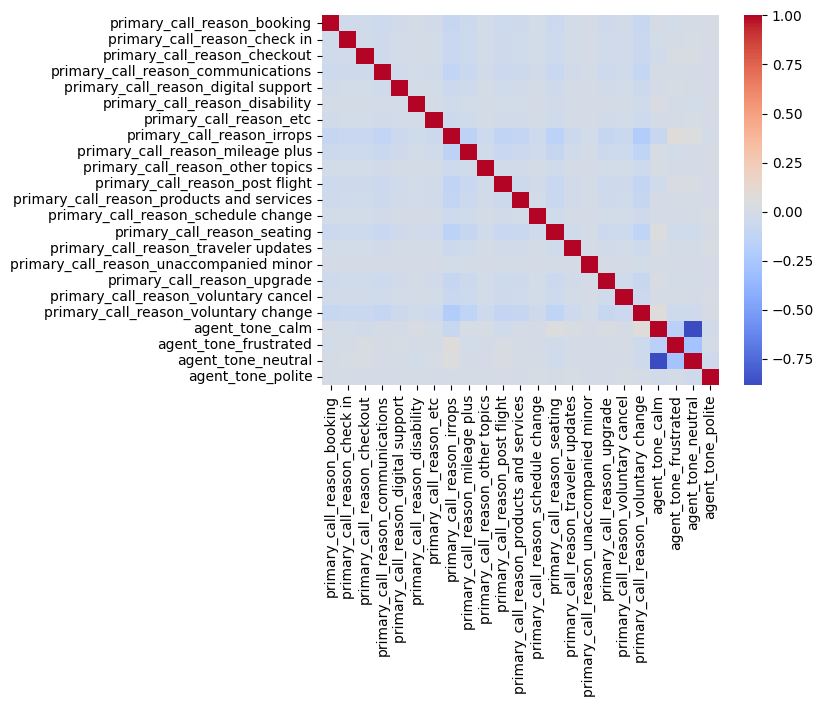

In [424]:
sns.heatmap(agent_reason_corr,cmap='coolwarm', fmt=".2f")

# Predictive model

In [598]:
call_reason_inner_join=calls.merge(reason,on="call_id",how="inner")

In [599]:
call_reason_inner_join

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,call_duration,wait_time,handle_time,normalise_handle_time,z_score,primary_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,1860.0,420.0,2280.0,7.731931,1.546469,voluntary cancel
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,720.0,180.0,900.0,6.802395,-0.107207,booking
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,1140.0,480.0,1620.0,7.390181,0.938485,irrops
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,420.0,300.0,720.0,6.579251,-0.504187,upgrade
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,540.0,600.0,1140.0,7.038784,0.313336,seating
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66648,7569738090,7367304988,783441,2024-08-31 23:51:00,2024-08-31 23:57:00,2024-09-01 00:07:00,\n\nAgent: Thank you for calling United Airlin...,600.0,360.0,960.0,6.866933,0.007609,mileage plus
66649,1563273072,8022667294,413148,2024-08-31 23:48:00,2024-08-31 23:57:00,2024-09-01 00:25:00,\n\nAgent: Thank you for calling United Airlin...,1680.0,540.0,2220.0,7.705262,1.499025,post flight
66650,8865997781,4474867021,980156,2024-08-31 23:55:00,2024-08-31 23:58:00,2024-09-01 00:06:00,\n\nAgent: Thank you for calling United Airlin...,480.0,180.0,660.0,6.492240,-0.658984,upgrade
66651,8019240181,9762042472,616988,2024-08-31 23:52:00,2024-08-31 23:58:00,2024-09-01 00:04:00,\n\nAgent: Thank you for calling United Airlin...,360.0,360.0,720.0,6.579251,-0.504187,upgrade


##### predictive model using TfidVectorizer and RandomForestClassifier

In [600]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Text feature extraction
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(call_reason_inner_join['call_transcript']).toarray()

# Label encoding
y = call_reason_inner_join['primary_call_reason']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Model evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))




Accuracy: 0.19773954790958193


C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

              baggage       0.00      0.00      0.00       853
              booking       0.00      0.00      0.00       795
             check in       0.00      0.00      0.00       569
             checkout       0.00      0.00      0.00       558
       communications       0.00      0.00      0.00      1132
      digital support       0.00      0.00      0.00       370
           disability       0.00      0.00      0.00       134
                  etc       0.00      0.00      0.00       302
               irrops       0.21      0.75      0.33      4070
         mileage plus       0.09      0.01      0.01      1748
         other topics       0.00      0.00      0.00       252
          post flight       0.11      0.00      0.00      1276
products and services       0.33      0.00      0.00       971
      schedule change       0.00      0.00      0.00       210
              seating       0.09      0.01      0.02  

C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Predictive model using logistic Regression

In [493]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Model evaluation
print(f"Logistic Regression accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Logistic Regression accuracy: 0.20004000800160032


C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

              baggage       0.14      0.00      0.00       853
              booking       0.00      0.00      0.00       795
             check in       0.00      0.00      0.00       569
             checkout       0.00      0.00      0.00       558
       communications       0.00      0.00      0.00      1132
      digital support       0.00      0.00      0.00       370
           disability       0.00      0.00      0.00       134
                  etc       0.00      0.00      0.00       302
               irrops       0.23      0.66      0.34      4070
         mileage plus       0.12      0.04      0.06      1748
         other topics       0.00      0.00      0.00       252
          post flight       0.13      0.04      0.06      1276
products and services       0.09      0.01      0.02       971
      schedule change       0.00      0.00      0.00       210
              seating       0.11      0.03      0.05  

C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVAN JYOTI\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Predictive model using RandomForestClassifier, RandomizedSearchCV and TfidVectorizer

In [495]:
# Sample the data to reduce size
sample_size = int(len(call_reason_inner_join) * 0.1)
call_reason_inner_join_sample = call_reason_inner_join.sample(n=sample_size, random_state=42)

# Vectorize the transcripts while keeping it sparse
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Adjust max_features
X = vectorizer.fit_transform(call_reason_inner_join_sample['call_transcript'])  # Keep as sparse matrix
y = call_reason_inner_join_sample['primary_call_reason']  # Replace with your target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False]
}

# Randomized Search
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit model on training data
clf_random.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_random.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy: 0.21
